In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

# Dane

In [5]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [6]:
data.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


In [7]:
num_feature1 = 'subject_yrsed'  # RECODE of ppeduc (Education (Highest Degree Received))
num_feature2 = 'w6_q21b_year'  # year subject began romantic relationship with partner
cat_feature1 = 'w6_q34'  # how would you describe the quality of your relationship with partner?
cat_feature2 = 'w6_otherdate_dichotomous'  # did subject meet someone last year (other than current partner)?
label = 'S1'  # Are you married?

In [8]:
data[num_feature1].describe()

count    3510.000000
mean       13.945868
std         2.546054
min         0.000000
25%        12.000000
50%        13.000000
75%        16.000000
max        20.000000
Name: subject_yrsed, dtype: float64

In [9]:
data[num_feature2].describe()

count    3276.000000
mean     1995.875153
std        16.741519
min      1942.000000
25%      1983.000000
50%      2000.000000
75%      2010.000000
max      2017.000000
Name: w6_q21b_year, dtype: float64

In [10]:
data[cat_feature1].describe()

count          2856
unique            6
top       Excellent
freq           1706
Name: w6_q34, dtype: object

In [11]:
data[cat_feature2].describe()

count     3363
unique       2
top         no
freq      3034
Name: w6_otherdate_dichotomous, dtype: object

In [12]:
data[cat_feature1].unique()

[NaN, Excellent, Good, Fair, Very Poor, Poor, Refused]
Categories (6, object): [Refused < Excellent < Good < Fair < Poor < Very Poor]

In [13]:
data[cat_feature2].unique()

[yes, no, NaN]
Categories (2, object): [no < yes]

In [14]:
data[label].describe()

count                  3510
unique                    2
top       Yes, I am Married
freq                   2085
Name: S1, dtype: object

In [15]:
data[label].unique()

[No, I am not Married, Yes, I am Married]
Categories (2, object): [Yes, I am Married < No, I am not Married]

In [16]:
le1 = LabelEncoder()
le2 = LabelEncoder()
df = data[[num_feature1, num_feature2, cat_feature1, cat_feature2, label]]
df = df.dropna()
encoded_cat1 = le1.fit_transform(df[cat_feature1])
encoded_cat2 = le2.fit_transform(df[cat_feature2])
df[cat_feature1] = encoded_cat1
df[cat_feature2] = encoded_cat2
df[label] = df[label].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
df.head()

,subject_yrsed,w6_q21b_year,w6_q34,w6_otherdate_dichotomous,S1
1,17.0,1995.0,0,0,1
2,17.0,2006.0,2,0,1
4,16.0,1983.0,0,0,1
5,12.0,1982.0,2,0,1
6,12.0,1967.0,0,0,1


In [17]:
df.describe()

,subject_yrsed,w6_q21b_year,w6_q34,w6_otherdate_dichotomous
count,2745.000000,2745.000000,2745.000000,2745.000000
mean,14.074499,1995.526047,0.767942,0.079781
std,2.524083,16.638284,1.019343,0.271004
min,0.000000,1942.000000,0.000000,0.000000
25%,12.000000,1983.000000,0.000000,0.000000
50%,13.000000,1999.000000,0.000000,0.000000
75%,16.000000,2010.000000,2.000000,0.000000
max,20.000000,2017.000000,5.000000,1.000000


# Model

In [36]:
X = df.drop(label, axis=1)
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
model = XGBClassifier()
model.fit(X_train.values, y_train.values)
pred_y = model.predict(X_test.values)
score = accuracy_score(pred_y, y_test)
print(f'Accuracy: {score}')

Accuracy: 0.8355167394468704


# LIME

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
def lime(n, obs_index, data, model, max_depth):
    X_new = np.zeros((n, data.shape[1]))
    X_new[:,:] = data.loc[obs_index,:].values
    for i in range(n):
        for j in range(X_new.shape[1]):
            X_new[i, j] = np.random.choice(data.values[:,j])
    y_blackbox = model.predict_proba(X_new)[:,1]
    X_old = np.zeros((n, data.shape[1]))
    X_old[:,:] = data.loc[obs_index,:].values
    dist = np.sqrt(((X_old - X_new) ** 2).sum(axis=1))
    dtr = DecisionTreeRegressor(max_depth=max_depth)
    dtr.fit(X_new[:, :], y_blackbox, sample_weight=dist)
    dot_data = StringIO()

    export_graphviz(dtr, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

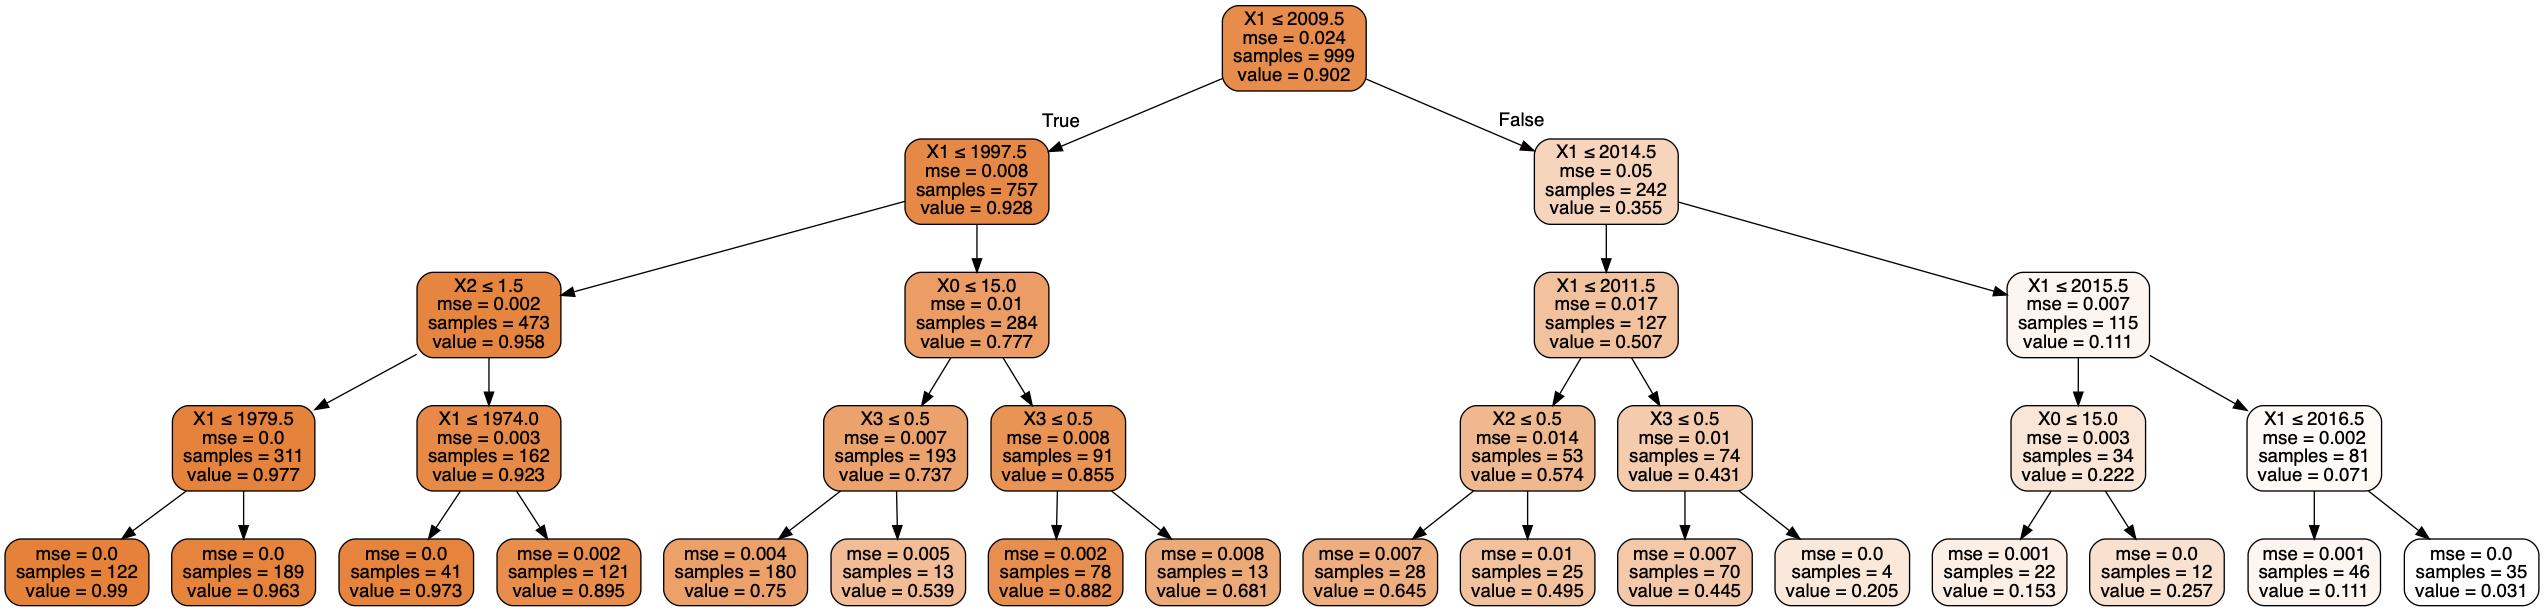

In [50]:
image = lime(n=1000, obs_index=2067, data=X, model=model, max_depth=4)
image

X0 - subject_yrsed, X1 - w6_q21b_year, X2 - w6_q34, X3 - w6_otherdate_dichotomous
    Patrząc na powyższe drzewo widzimy, że największy wpływ ma zmienna X1 jako że w większości wierzchołków jest zmienną podziału, co jest porównywalne z metodą Break down gdzie rok ma najwiękzy wpływ na odpowiedź, a wpływ innych zmiennych jest drugorzędny.

In [52]:
X.iloc[2067, :]

subject_yrsed                 13.0
w6_q21b_year                2000.0
w6_q34                         0.0
w6_otherdate_dichotomous       0.0
Name: 2666, dtype: float64

In [53]:
X.iloc[365, :]

subject_yrsed                 16.0
w6_q21b_year                1987.0
w6_q34                         2.0
w6_otherdate_dichotomous       0.0
Name: 478, dtype: float64

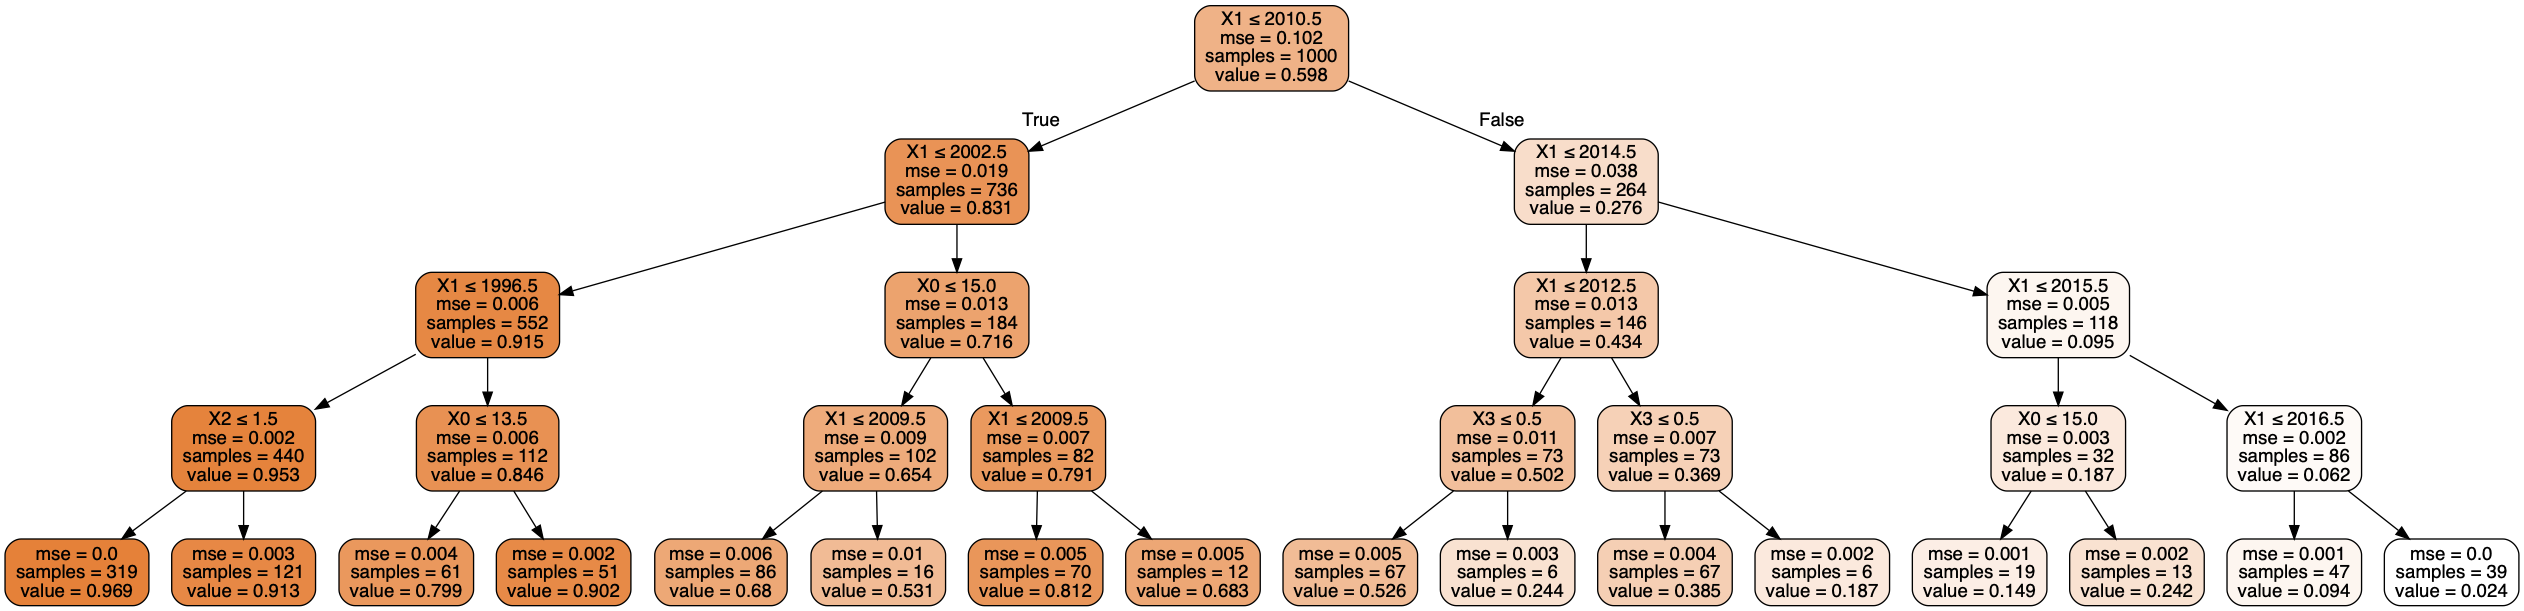

In [54]:
image = lime(n=1000, obs_index=365, data=X, model=model, max_depth=4)
image

# Wykresy Break Down

In [67]:
import waterfall_chart

def mean_responses(model, data, sample, feature_list):
    
    X_temp = data.copy()
    probabilities = []
    diffs = []
    
    temp_y = []
    
    for k in range(len(X_temp)):
        prob_single_sample = model.predict_proba(X_temp.iloc[[k]])[0,1]
        temp_y.append(prob_single_sample)
        
    # mean for model
        
    mean_prob = np.mean(temp_y)
    probabilities.append(mean_prob)
    diffs.append(probabilities[0])
    
    # ordering
    
    for i in range(len(feature_list)):
        X_temp.loc[:,feature_list[i]] = int(sample[feature_list[i]])
        temp_y = []
        
        for j in range(len(X_temp)):
            prob_single_sample = model.predict_proba(X_temp.iloc[[j]])[0,1]
            temp_y.append(prob_single_sample)
        
        mean_prob = np.mean(temp_y)
        probabilities.append(mean_prob)
        
        diffs.append(probabilities[i+1]-probabilities[i])
    
    waterfall_chart.plot(['base'] + feature_list, diffs, Title = "Model mean response", formatting='{:,.2f}',
                        rotation_value = 60)

In [79]:
sample = X.sample()
print(sample)

      subject_yrsed  w6_q21b_year  w6_q34  w6_otherdate_dichotomous
2067           12.0        2015.0       1                         0


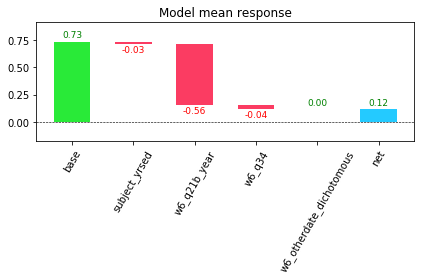

In [80]:
mean_responses(model, X, sample, ['subject_yrsed','w6_q21b_year','w6_q34','w6_otherdate_dichotomous'])

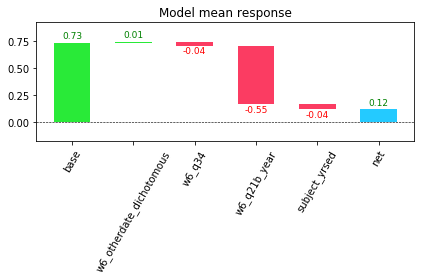

In [81]:
mean_responses(model, X, sample, ['w6_otherdate_dichotomous','w6_q34','w6_q21b_year','subject_yrsed'])

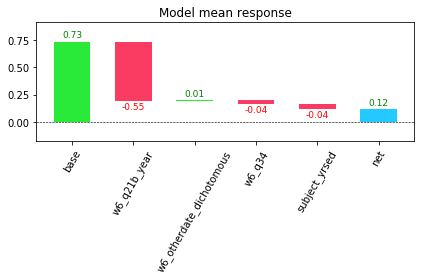

In [82]:
mean_responses(model, X, sample, ['w6_q21b_year','w6_otherdate_dichotomous','w6_q34','subject_yrsed'])

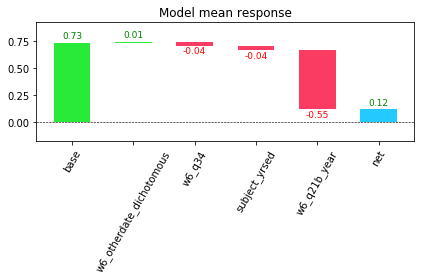

In [83]:
mean_responses(model, X, sample, ['w6_otherdate_dichotomous','w6_q34','subject_yrsed', 'w6_q21b_year'])

In [73]:
sample = X.sample()
print(sample)

     subject_yrsed  w6_q21b_year  w6_q34  w6_otherdate_dichotomous
365           13.0        1970.0       2                         0


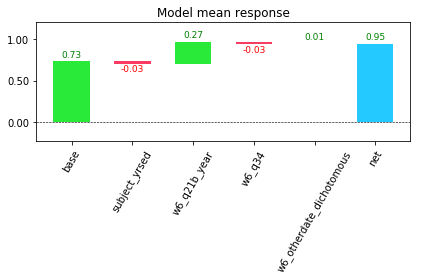

In [74]:
mean_responses(model, X, sample, ['subject_yrsed','w6_q21b_year','w6_q34','w6_otherdate_dichotomous'])

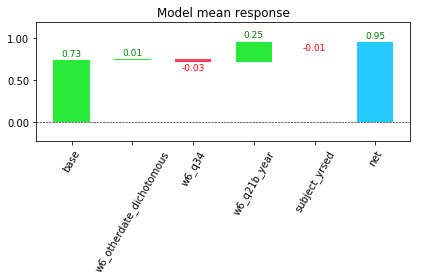

In [75]:
mean_responses(model, X, sample, ['w6_otherdate_dichotomous','w6_q34','w6_q21b_year','subject_yrsed'])

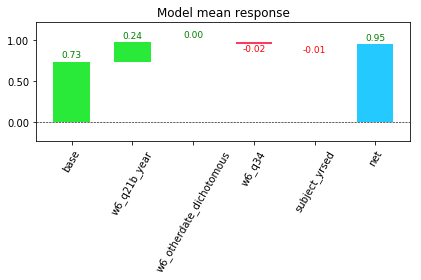

In [76]:
mean_responses(model, X, sample, ['w6_q21b_year','w6_otherdate_dichotomous','w6_q34','subject_yrsed'])

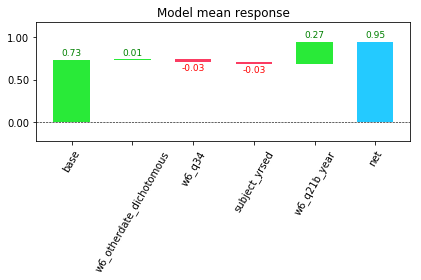

In [77]:
mean_responses(model, X, sample, ['w6_otherdate_dichotomous','w6_q34','subject_yrsed', 'w6_q21b_year'])

# Wnioski
### BreakDown
* Zmienna w6_q21b_year ma największy wpływ na odpowiedź co wynika z jej przestawiania w kolejności i największej zmiany wśród innych zmiennych, co jest bliskie intuicji że jest ważne kiedy był początek relacji
* Zmiana kolejności innych zmiennych nie ma dużego wpływu na odchylenie odpowiedzi modelu
### LIME
* X0 - subject_yrsed, X1 - w6_q21b_year, X2 - w6_q34, X3 - w6_otherdate_dichotomous Patrząc na powyższe drzewo widzimy, że największy wpływ ma zmienna X1 jako że w większości wierzchołków jest zmienną podziału, co jest porównywalne z metodą Break down gdzie rok ma najwiękzy wpływ na odpowiedź, a wpływ innych zmiennych jest drugorzędny.